# Test online learning in DeepNets



The idea here is to train a model on 1 data point at a time so mimic online setting and compare the results with batch_size >1 setting

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
from time import time


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

In [3]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train_org, y_train_org), (X_test_org, y_test_org) = mnist.load_data()
print("X_train original shape", X_train_org.shape)
print("y_train original shape", y_train_org.shape)
print("X_test original shape", X_test_org.shape)
print("y_test original shape", y_test_org.shape)

11501568/11490434 [==============================] - 0s 0us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)
X_test original shape (10000, 28, 28)
y_test original shape (10000,)


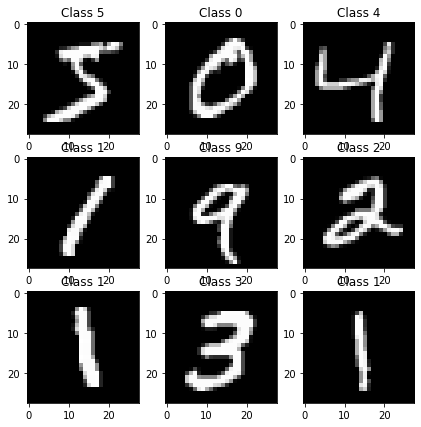

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train_org[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train_org[i]))

In [5]:
X_train = X_train_org
y_train = y_train_org
X_test = X_test_org
y_test = y_test_org

In [6]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [7]:
# get 1-hot representation for the 10 classes
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [8]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.4))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [19]:
offline_history = model.fit(X_train, Y_train,
          batch_size=128, epochs=6,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/6
469/469 [==============================] - 3s 6ms/step - loss: 0.0465 - accuracy: 0.9854 - val_loss: 0.0684 - val_accuracy: 0.9825
Epoch 2/6
469/469 [==============================] - 3s 5ms/step - loss: 0.0435 - accuracy: 0.9861 - val_loss: 0.0619 - val_accuracy: 0.9833
Epoch 3/6
469/469 [==============================] - 2s 5ms/step - loss: 0.0412 - accuracy: 0.9869 - val_loss: 0.0664 - val_accuracy: 0.9835
Epoch 4/6
469/469 [==============================] - 2s 5ms/step - loss: 0.0392 - accuracy: 0.9881 - val_loss: 0.0630 - val_accuracy: 0.9826
Epoch 5/6
469/469 [==============================] - 2s 5ms/step - loss: 0.0336 - accuracy: 0.9894 - val_loss: 0.0665 - val_accuracy: 0.9830
Epoch 6/6
469/469 [==============================] - 2s 5ms/step - loss: 0.0365 - accuracy: 0.9881 - val_loss: 0.0683 - val_accuracy: 0.9831


In [ ]:
#model.predict_classes(X_test)

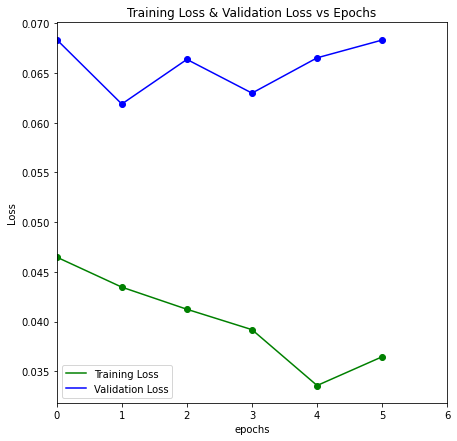

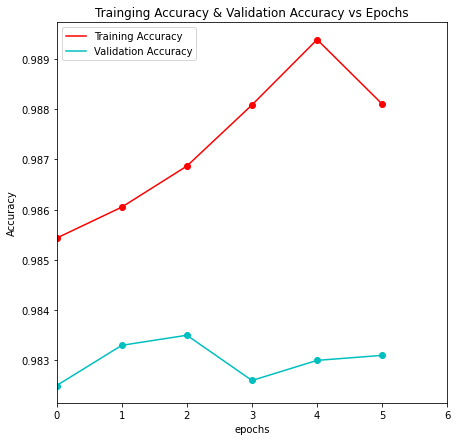

In [23]:
hist = offline_history

plt.figure(1)

axes = plt.gca()
x_min = hist.epoch[0]
x_max = hist.epoch[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(hist.epoch, hist.history['loss'], color='g')
plt.plot(hist.history['loss'], color='g', label='Training Loss')
plt.scatter(hist.epoch, hist.history['val_loss'], color='b')
plt.plot(hist.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss & Validation Loss vs Epochs')
plt.legend()

plt.figure(2)

axes = plt.gca()
x_min = hist.epoch[0]
x_max = hist.epoch[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(hist.epoch, hist.history['accuracy'], color='r')
plt.plot(hist.history['accuracy'], color='r', label='Training Accuracy')
plt.scatter(hist.epoch, hist.history['val_accuracy'], color='c')
plt.plot(hist.history['val_accuracy'], color='c', label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Trainging Accuracy & Validation Accuracy vs Epochs')
plt.legend()

plt.show()

In [25]:
loss, acc = model.evaluate(X_test, Y_test,
                       verbose=1)
print('Test score:', loss)
print('Test accuracy:', acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.9831
Test score: 0.06830894947052002
Test accuracy: 0.9830999970436096


In [31]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = np.argmax(model.predict(X_test),axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

In [32]:
len(correct_indices)

9831

In [33]:
len(incorrect_indices)

169

## Lets go the online way !

In [34]:
model_online_1 = Sequential()
model_online_1.add(Dense(512, input_shape=(784,)))
model_online_1.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model_online_1.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model_online_1.add(Dense(512))
model_online_1.add(Activation('relu'))
model_online_1.add(Dropout(0.2))
model_online_1.add(Dense(10))
model_online_1.add(Activation('softmax'))

In [36]:
model_online_1.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [37]:
no_of_samples = len(X_train)

batch_size = 1
nb_classes = 10
nb_epoch = 1
start_time = 0
end_time = 0

In [38]:
from keras.callbacks import Callback

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [39]:
online_history = LossHistory()

In [43]:
def compute_regret(model,X,Y):
    
    predicted_classes = np.argmax(model.predict(X),axis=1)
    
    correct_indices = np.nonzero(predicted_classes == Y)[0]
    incorrect_indices = np.nonzero(predicted_classes != Y)[0]
    
    return (correct_indices, incorrect_indices)

In [45]:
#no_of_samples = 5000
from tqdm.notebook import tqdm
# store regrets for train and test - regret is a tuple (correct_indices, incorrect_indices)
train_regret_list = []
test_regret_list = []

# store (loss,accuracy) for train and test data
train_score_list = []
test_score_list = []

REGRET_CHECKPOINT = 250
ITERATION_CHECKPOINT = 250
tbar = TQDMProgressBar(
        update_per_second=1,
        leave_epoch_progress=False,
        leave_overall_progress=False,
        show_epoch_progress=False
    )

for i in tqdm(range(no_of_samples)):
    
    # print info after consuming 1000 data points
    if ((i+1)%ITERATION_CHECKPOINT == 0):
        print(f"Example : {i}")
        end_time = time()
        time_lapse = end_time - start_time
        print("Training on 1000 point took %.2f secs" %(end_time - start_time))
        start_time = time()
        #start_time = time()

    # train on ith data point
    model_online_1.fit(X_train[i:i+1,:], Y_train[i:i+1],
          batch_size, epochs=1, callbacks=[tbar],
          verbose=0)
    
    #calculate regret on train and test
    if ((i+1)%REGRET_CHECKPOINT == 0):
        
        # compute regrets and store it
        train_regret = compute_regret(model_online_1,X_train,y_train_org)
        test_regret = compute_regret(model_online_1,X_test,y_test_org)
        train_regret_list.append(train_regret)
        test_regret_list.append(test_regret)
        
        # compute scores and store them
        train_score = model_online_1.evaluate(X_train, Y_train,  verbose=0)
        test_score = model_online_1.evaluate(X_test, Y_test,  verbose=0)
        print('train_score:{train_score} test_score:{test_score}')
        train_score_list.append(train_score)
        test_score_list.append(test_score)

Example : %d 999
Training on 1000 point took 1641720702.22 secs
Example : %d 1999
Training on 1000 point took 133.89 secs
Example : %d 2999
Training on 1000 point took 130.46 secs
Example : %d 3999
Training on 1000 point took 131.59 secs
Example : %d 4999
Training on 1000 point took 141.93 secs
Example : %d 5999
Training on 1000 point took 178.85 secs
Example : %d 6999
Training on 1000 point took 174.11 secs
Example : %d 7999
Training on 1000 point took 155.53 secs
Example : %d 8999
Training on 1000 point took 135.46 secs
Example : %d 9999
Training on 1000 point took 134.64 secs
Example : %d 10999
Training on 1000 point took 130.99 secs
Example : %d 11999
Training on 1000 point took 131.31 secs
Example : %d 12999
Training on 1000 point took 131.83 secs
Example : %d 13999
Training on 1000 point took 132.63 secs
Example : %d 14999
Training on 1000 point took 130.49 secs
Example : %d 15999
Training on 1000 point took 131.25 secs
Example : %d 16999
Training on 1000 point took 130.29 secs
E

In [46]:
plt.figure(3)

X_vals = [i for i in xrange(0,no_of_samples,REGRET_CHECKPOINT)]

Train_regrets = [len(val[1]) for val in train_regret_list]
Test_regrets = [len(val[1]) for val in test_regret_list]


axes = plt.gca()
x_min = X_vals[0]
x_max = X_vals[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(X_vals, Train_regrets, color='r')
plt.plot(X_vals, Train_regrets, color='r', label='# Train Regrets')

plt.scatter(X_vals, Test_regrets, color='g')
plt.plot(X_vals, Test_regrets, color='g', label='# Test Regrets')

plt.xlabel('# of Data Points')
plt.ylabel('# of Regrets')
plt.title('Training & Test Data -  # of Regrets vs # of Data Points')
plt.legend()

plt.show()


NameError: name 'xrange' is not defined

<Figure size 504x504 with 0 Axes>

In [ ]:
plt.figure(4)

X_vals = [i for i in xrange(0,no_of_samples,50)]

Train_accuracy = [val[1] for val in train_score_list]
Test_accuracy = [val[1] for val in test_score_list]


axes = plt.gca()
x_min = X_vals[0]
x_max = X_vals[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(X_vals, Train_accuracy, color='r')
plt.plot(X_vals, Train_accuracy, color='r', label='# Training accuracy')

plt.scatter(X_vals, Test_accuracy, color='g')
plt.plot(X_vals, Test_accuracy, color='g', label='# Testing accuracy')

plt.xlabel('# of Data Points')
plt.ylabel('# of Regrets')
plt.title('Training & Test Data -  # of Regrets vs # of Data Points')
plt.legend()

plt.show()

In [ ]:
# get the final numbers

In [ ]:
correct, incorrect = compute_regret(model_online_1,X_test,y_test_org)
print len(correct)
print len(incorrect)

In [ ]:
# train & test data accuracy

print train_score_list[-1][1]

print test_score_list[-1][1]

## ReRun the same thing but this time on each Datapoint we run 3 epochs

In [ ]:
# train another model but this time for ech datapoint I run 3 epochs.

model_online_3 = Sequential()
model_online_3.add(Dense(512, input_shape=(784,)))
model_online_3.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model_online_3.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model_online_3.add(Dense(512))
model_online_3.add(Activation('relu'))
model_online_3.add(Dropout(0.2))
model_online_3.add(Dense(10))
model_online_3.add(Activation('softmax'))

In [ ]:
model_online_3.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [ ]:
# store regrets for train and test - regret is a tuple (correct_indices, incorrect_indices)
train_regret_list = []
test_regret_list = []

# store (loss,accuracy) for train and test data
train_score_list = []
test_score_list = []

#REGRET_CHECKPOINT = 50
#ITERATION_CHECKPOINT = 1000


for i in range(no_of_samples):
    
    # print info after consuming 1000 data points
    if ((i+1)%ITERATION_CHECKPOINT == 0):
        print("Example : %d", i)
        end_time = time()
        time_lapse = end_time - start_time
        print("Training on 1000 point took %.2f secs" %(end_time - start_time))
        start_time = time()
        #start_time = time()

    # train on ith data point
    model_online_3.fit(X_train[i:i+1,:], Y_train[i:i+1],
          batch_size, epochs=4,
          show_accuracy=True, verbose=0)
    
    #calculate regret on train and test
    if ((i+1)%REGRET_CHECKPOINT == 0):
        
        # compute regrets and store it
        train_regret = compute_regret(model_online_3,X_train,y_train_org)
        test_regret = compute_regret(model_online_3,X_test,y_test_org)
        train_regret_list.append(train_regret)
        test_regret_list.append(test_regret)
        
        # compute scores and store them
        train_score = model_online_3.evaluate(X_train, Y_train,  verbose=0)
        test_score = model_online_3.evaluate(X_test, Y_test,  verbose=0)
        train_score_list.append(train_score)
        test_score_list.append(test_score)

In [ ]:
plt.figure(5)

X_vals = [i for i in xrange(0,no_of_samples,REGRET_CHECKPOINT)]

Train_regrets = [len(val[1]) for val in train_regret_list]
Test_regrets = [len(val[1]) for val in test_regret_list]


axes = plt.gca()
x_min = X_vals[0]
x_max = X_vals[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(X_vals, Train_regrets, color='r')
plt.plot(X_vals, Train_regrets, color='r', label='# Train Regrets')

plt.scatter(X_vals, Test_regrets, color='g')
plt.plot(X_vals, Test_regrets, color='g', label='# Test Regrets')

plt.xlabel('# of Data Points')
plt.ylabel('# of Regrets')
plt.title('Training & Test Data -  # of Regrets vs # of Data Points')
plt.legend()

plt.show()

In [ ]:
plt.figure(4)

X_vals = [i for i in xrange(0,no_of_samples,50)]

Train_accuracy = [val[1] for val in train_score_list]
Test_accuracy = [val[1] for val in test_score_list]


axes = plt.gca()
x_min = X_vals[0]
x_max = X_vals[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(X_vals, Train_accuracy, color='r')
plt.plot(X_vals, Train_accuracy, color='r', label='# Training accuracy')

plt.scatter(X_vals, Test_accuracy, color='g')
plt.plot(X_vals, Test_accuracy, color='g', label='# Testing accuracy')

plt.xlabel('# of Data Points')
plt.ylabel('# of Regrets')
plt.title('Training & Test Data -  # of Regrets vs # of Data Points')
plt.legend()

plt.show()

In [ ]:
# get the final numbers

In [ ]:
correct, incorrect = compute_regret(model_online_3,X_test,y_test_org)
print len(correct)
print len(incorrect)

In [ ]:
# train & test data accuracy

print train_score_list[-1][1]

print test_score_list[-1][1]